<a href="https://colab.research.google.com/github/TirendazAcademy/Deep-Learning-with-TensorFlow/blob/main/ML-Approach-for-Time-Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

# How to analyze time series in practice?

In [3]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5,shift=1,drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


## Creating labels

In [4]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


## Optimizing the dataset

In [5]:
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

x =  [[2 3 4 5]
 [4 5 6 7]]
y =  [[6]
 [8]]
x =  [[0 1 2 3]
 [5 6 7 8]]
y =  [[4]
 [9]]
x =  [[1 2 3 4]
 [3 4 5 6]]
y =  [[5]
 [7]]


# Creating a synthetic time series

In [6]:
import numpy as np

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
            np.cos(season_time * 2 * np.pi),
            1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [7]:
time = np.arange(4*365+1,dtype="float32")

baseline = 10
series = trend(time, .05)
amplitude = 15
slope=0.09
noise_level = 6

series = baseline+trend(time,slope)+seasonality(time,period=365,
                                                amplitude=amplitude)
series +=noise(time, noise_level, seed = 42)

# Windowed approach

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window:(window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

# Splitting the dataset

In [9]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

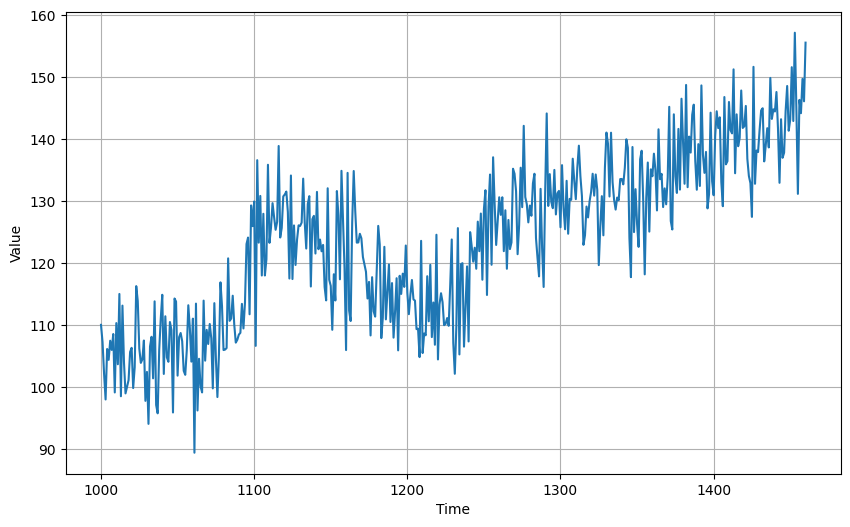

In [10]:
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [11]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [12]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [14]:
for feature, label in dataset.take(1):
  print(feature[:1])
  print(label[:1])

tf.Tensor(
[[29.37475  30.0047   23.900368 29.428837 29.848835 23.859667 39.396076
  31.100363 21.16576  32.3094   22.578753 33.206387 35.49276  23.674671
  34.43686  31.191393 33.705433 40.212456 27.418251 24.427298]], shape=(1, 20), dtype=float32)
tf.Tensor([23.672016], shape=(1,), dtype=float32)


# Buildning the model

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size],
                           activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse",
              optimizer=tf.keras.optimizers.Adam())

model.fit(dataset,epochs=100)

# Prediction

In [20]:
print(series[1020])

106.32034


In [21]:
print(model.predict(series[1000:1020][np.newaxis]))

1/1 [==============================] - 0s 116ms/step
[[104.3047]]


In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

In [23]:
len(forecast)

1441

In [24]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

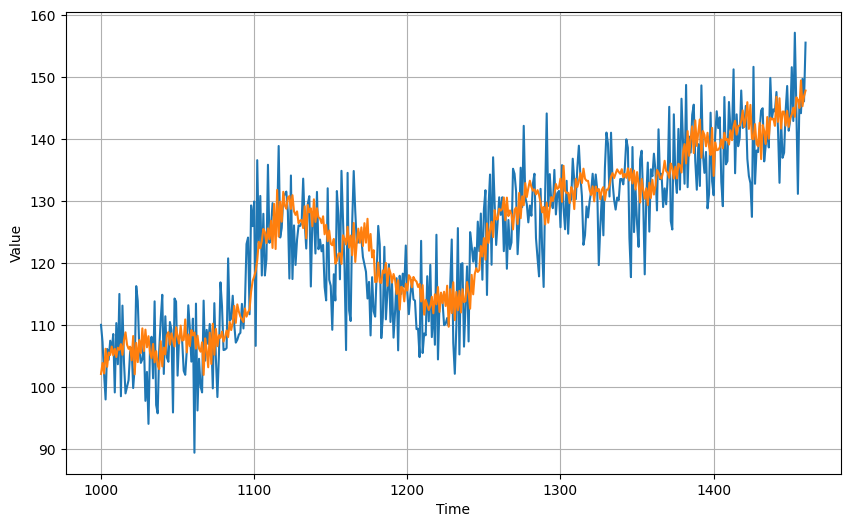

In [25]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [29]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

44.95037
5.3951135
